In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!pip install shap
!pip install bayesian-optimization
!pip install lightgbm
!pip install imblearn

     |████████████████████████████████| 266kB 48.6MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383170 sha256=bba0df8ed34ecd05b71d035d1504c387524ba571af17a42d7290f828ac8ba660
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

train = pd.read_csv('/gdrive/My Drive/Data/train.csv', index_col=0)
test = pd.read_csv('/gdrive/My Drive/Data/test.csv', index_col=0)
sample_submission = pd.read_csv('/gdrive/My Drive/Data/sample_submission.csv', index_col=0)
scaler = StandardScaler()

column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))
train.drop("type",axis = 1,inplace=True)


train_yk = train[["type_num","fiberID"]]
train1 = train.drop(["type_num","fiberID"],axis=1)
feature_col = train1.columns
train_k = train1[train1[feature_col] < -2000]
train_k1 = train1[train1[feature_col] > 1000]
pre_index1 = set(train_k.dropna(how="all",axis=0).index)
pre_index2 = set(train_k1.dropna(how="all",axis=0).index)
pre_index = list(pre_index1|pre_index2)
train1 = train1.drop(pre_index,axis=0).reset_index(drop=True)
train_yk = train_yk.drop(pre_index,axis=0).reset_index(drop=True)
train = pd.concat([train_yk,train1[feature_col]],axis=1)
train = train.drop(train[(train["fiberMag_r"]<0)|(train["fiberMag_g"]<0)|(train["fiberMag_u"]<5)|(train["psfMag_r"]<0)|(train["psfMag_u"]>50)|(train["psfMag_z"]<5)|(train["psfMag_i"]>100)|
                        (train['petroMag_u']>100)|(train['petroMag_g']<-300)|(train['petroMag_z']<-100)|(train["psfMag_u"]<-20)|(train["fiberMag_u"]>100)
                        |(train['petroMag_i']<-20)|(train['modelMag_z']>40)|(train['modelMag_u']<10)|(train['petroMag_r']<-40)
                        |(train['petroMag_z']>150)|(train['petroMag_u']<-150)|(train['petroMag_r']>90)|(train['petroMag_i']>100)
                        |(train['petroMag_g']>200)|(train['modelMag_z']<10)|(train['modelMag_g']<10)].index).reset_index(drop=True)
# train = train.drop([76848,107571,162907,118359],axis=0).reset_index(drop=True)
test.loc[207051,'petroMag_g'] = -200
test.loc[207051,'psfMag_g'] = 100

In [140]:
train2 = train[["fiberID","type_num"]]
train2["count"] =1
train2_g = train2.groupby(["fiberID","type_num"]).count().unstack("type_num")
train2_g.fillna(0,inplace=True)
train_value = train["type_num"].value_counts().sort_index()
train2_g.columns = sample_submission.columns
for i, col in enumerate(train2_g.columns):
    train2_g[col] = train2_g[col]*100 / train_value[i]
train2_g.reset_index(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# train = train.merge(train2_g,on="fiberID")
# test = test.merge(train2_g,on="fiberID")
train_x = train.drop('type_num', axis=1)
train_y = train['type_num']
test_x = test
sc_col = train_x.iloc[:,:21].columns
not_col = train_x.columns.difference(sc_col)
tr_ind =  train_x.index
te_ind = test_x.index

In [142]:
train2_g.shape

(1000, 20)

In [143]:
test_x.describe()

,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000
mean,359.327805,20.987400,19.870182,19.280218,18.873165,18.618385,21.184506,20.091376,19.497732,19.083329,18.826624,20.715429,19.576725,18.995001,18.616519,18.411996,20.739001,19.534844,18.935095,18.522308,18.281069
std,223.928862,2.111703,2.149137,1.709344,1.720713,1.702236,1.990940,1.865064,1.710070,1.633953,1.711790,2.807434,3.623440,1.979225,1.970463,2.373022,2.187025,1.957506,1.856617,1.796820,1.867582
min,1.000000,-7.248195,-42.663871,9.134712,-22.522266,13.349827,9.390439,8.188752,12.288183,12.688984,-8.455932,-98.181975,-200.000000,-23.908952,-8.356654,-64.917293,12.419765,13.617577,13.382832,12.955113,12.395695
25%,174.000000,19.655525,18.671025,18.037847,17.742016,17.424701,19.940430,18.892043,18.253627,17.905253,17.610776,19.249432,18.104265,17.475078,17.043615,16.805557,19.268471,18.064625,17.424393,16.971911,16.715685
50%,346.000000,20.854404,19.910333,19.444925,19.033283,18.594713,21.040735,20.071658,19.627904,19.180605,18.699819,20.371014,19.582955,19.197068,18.684269,18.171966,20.412702,19.541261,19.155839,18.635195,18.095883
75%,525.000000,22.160801,21.150040,20.489912,20.083814,19.878652,22.339213,21.402558,20.756306,20.331848,20.119736,21.803705,21.025719,20.428279,20.015701,19.815916,21.992969,20.981396,20.389215,19.970657,19.823902
max,1000.000000,37.681143,100.000000,31.883768,47.227391,34.946057,41.169991,47.160580,29.266687,31.146742,26.478564,65.392087,106.962571,41.850633,52.221528,74.747394,32.641240,28.814977,27.579664,26.471555,24.461973


In [0]:
set_d = pd.concat([train_x[sc_col],test_x[sc_col]],axis=0)
set_data = pd.DataFrame()
for i in sc_col:
  if i=='fiberID':
    set_data[i] = set_d[i]
  else:
    set_data[i] = set_d[i]-set_d[i].min()+100
    set_data[i] = np.log(set_data[i])
set_data = set_data.merge(train2_g,on = 'fiberID',how='left')
set_data.drop('fiberID',axis=1,inplace=True)

In [155]:
set_data

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
0,4.950229,5.100451,4.763770,5.023146,4.737051,4.755082,4.740750,4.731149,4.707194,4.867756,5.410297,5.948263,5.058518,4.915362,5.327765,4.704621,4.691049,4.710226,4.697596,4.702025,0.138953,0.153728,0.0,0.078125,0.225795,0.222338,0.136755,0.236407,0.072505,0.0,0.174609,0.336289,0.0,0.168303,0.245776,0.218744,0.519931,0.0,0.211485
1,4.937637,5.096030,4.758334,5.020026,4.730912,4.748930,4.735368,4.725042,4.703123,4.863832,5.405172,5.946558,5.054770,4.911647,5.328853,4.693182,4.684539,4.704717,4.694608,4.696244,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.128897,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,4.911629,5.071365,4.723419,4.993194,4.696541,4.716387,4.699650,4.689216,4.667669,4.832564,5.389350,5.935937,5.027608,4.882555,5.310062,4.658950,4.646305,4.666776,4.657029,4.660715,0.138953,0.169101,0.2,0.078125,0.157373,0.192693,0.158207,0.128949,0.068477,0.0,0.247363,0.076429,0.0,0.154278,0.092166,0.177729,0.000000,0.0,0.147120
3,4.933027,5.091934,4.751862,5.014333,4.721966,4.741717,4.729093,4.718375,4.695259,4.853985,5.400999,5.944502,5.048986,4.905083,5.323058,4.686546,4.677524,4.696864,4.686019,4.687446,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.140981,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,4.973031,5.110316,4.765111,5.012080,4.712363,4.781578,4.757932,4.731899,4.693319,4.846282,5.425184,5.950857,5.059758,4.904039,5.317781,4.723702,4.706371,4.711226,4.683518,4.676545,0.277906,0.169101,0.0,0.039062,0.218953,0.155636,0.171614,0.236407,0.128897,0.0,0.130957,0.305717,0.0,0.294530,0.215054,0.239251,0.346620,0.0,0.188497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209841,4.925615,5.088869,4.747642,5.011101,4.721023,4.733433,4.724754,4.713865,4.691717,4.854103,5.398509,5.943337,5.045593,4.901762,5.323196,4.677485,4.673187,4.692682,4.682492,4.685622,0.185271,0.292083,0.2,0.078125,0.171057,0.140814,0.131392,0.085966,0.056392,0.0,0.138232,0.183430,0.0,0.280505,0.245776,0.170893,0.000000,0.0,0.142522
209842,4.927030,5.089282,4.746659,5.011323,4.720146,4.735424,4.725653,4.713706,4.692422,4.850960,5.399425,5.943563,5.045106,4.902930,5.322744,4.680034,4.673825,4.691781,4.682722,4.683816,0.092635,0.030746,0.2,0.117188,0.225795,0.125991,0.179658,0.128949,0.042294,0.0,0.109131,0.198716,0.0,0.140252,0.122888,0.170893,0.000000,0.0,0.183900
209843,4.936134,5.093382,4.753276,5.014887,4.724663,4.743595,4.731158,4.719695,4.696419,4.855044,5.403541,5.945344,5.050596,4.907362,5.325656,4.689076,4.679882,4.699158,4.687382,4.691133,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.036252,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
209844,4.939028,5.101624,4.761885,5.023247,4.737184,4.750437,4.743416,4.730736,4.708221,4.868286,5.409474,5.948485,5.057199,4.915733,5.332169,4.695083,4.692186,4.708100,4.701326,4.702692,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.145009,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


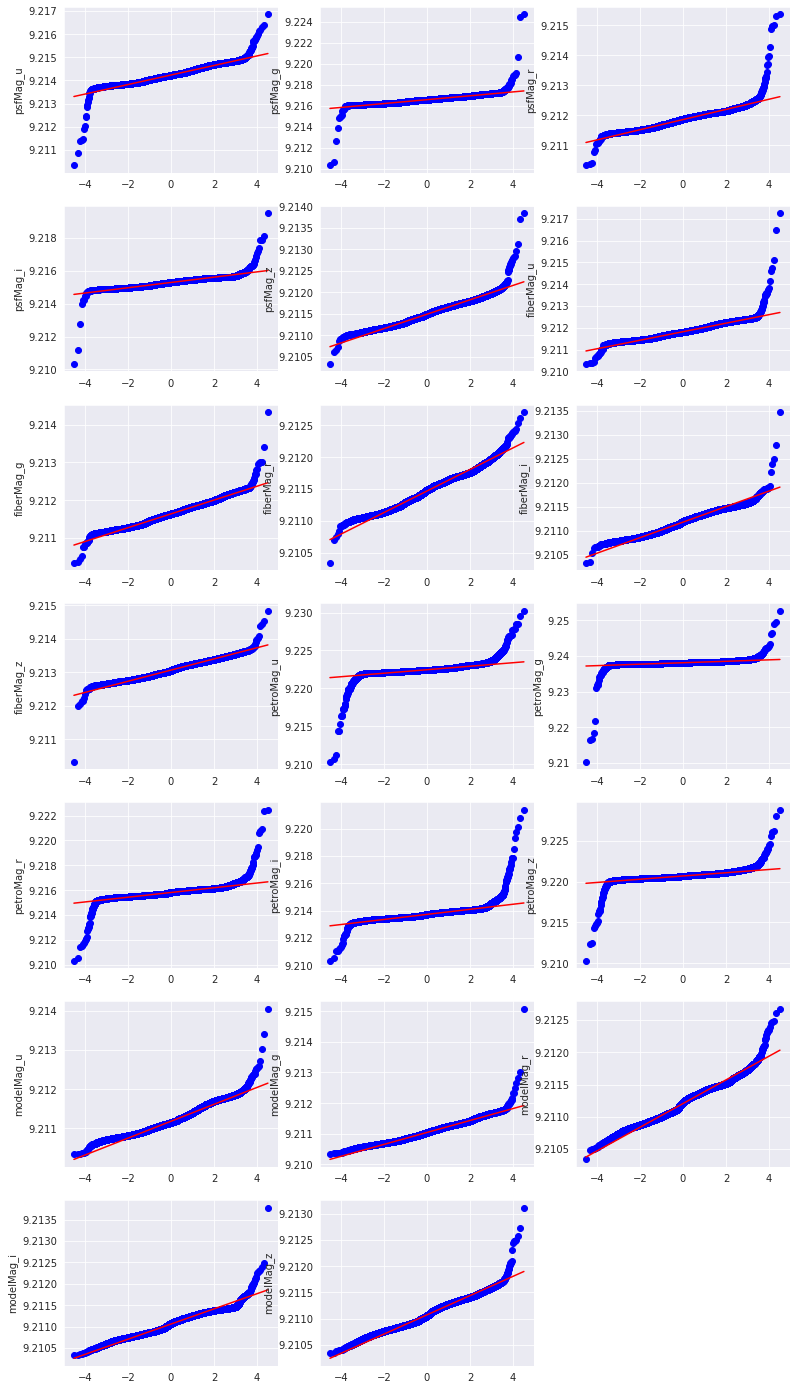

In [75]:
import scipy as sp
sns.set_style("darkgrid")
plt.figure(figsize=(13,25))
for i, col in enumerate(sc_col):
    plt.subplot(7,3,i+1)
    sp.stats.probplot(set_data.iloc[:,i], plot=plt)
    plt.title("")
    plt.xlabel("")
    plt.ylabel(col)

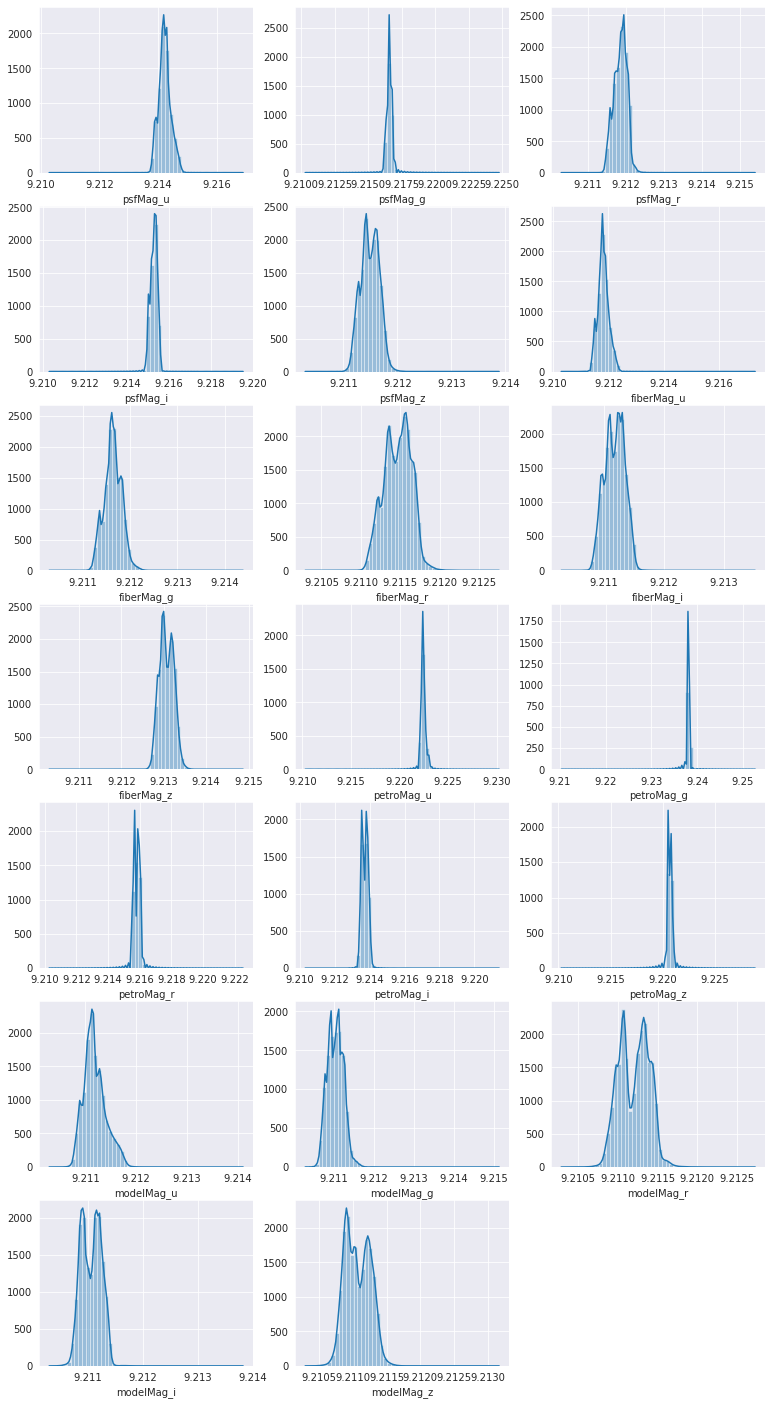

In [76]:
sns.set_style("darkgrid")
plt.figure(figsize=(13,25))
for i, col in enumerate(sc_col):
    plt.subplot(7,3,i+1)
    sns.distplot(set_data[col])

fiberID  optimal lambda: 3.890966334392629
psfMag_u  optimal lambda: 2.3987131836492384
psfMag_g  optimal lambda: 5.0285561023882375
psfMag_r  optimal lambda: 4.886624569844974
psfMag_i  optimal lambda: 9.15490279808937
psfMag_z  optimal lambda: 3.298379712687648
fiberMag_u  optimal lambda: -1.1518243174753384
fiberMag_g  optimal lambda: 3.4259529787054035
fiberMag_r  optimal lambda: 6.195284471045624
fiberMag_i  optimal lambda: 5.409380708543046
fiberMag_z  optimal lambda: 2.285041796234708
petroMag_u  optimal lambda: 7.77038985413653
petroMag_g  optimal lambda: 14.661673448783642
petroMag_r  optimal lambda: 5.34434320171944
petroMag_i  optimal lambda: -0.05357583886874756
petroMag_z  optimal lambda: 8.096274582483511
modelMag_u  optimal lambda: -5.215709590771432
modelMag_g  optimal lambda: 0.7921384734758337
modelMag_r  optimal lambda: 3.821355892549989
modelMag_i  optimal lambda: 3.321504958317423


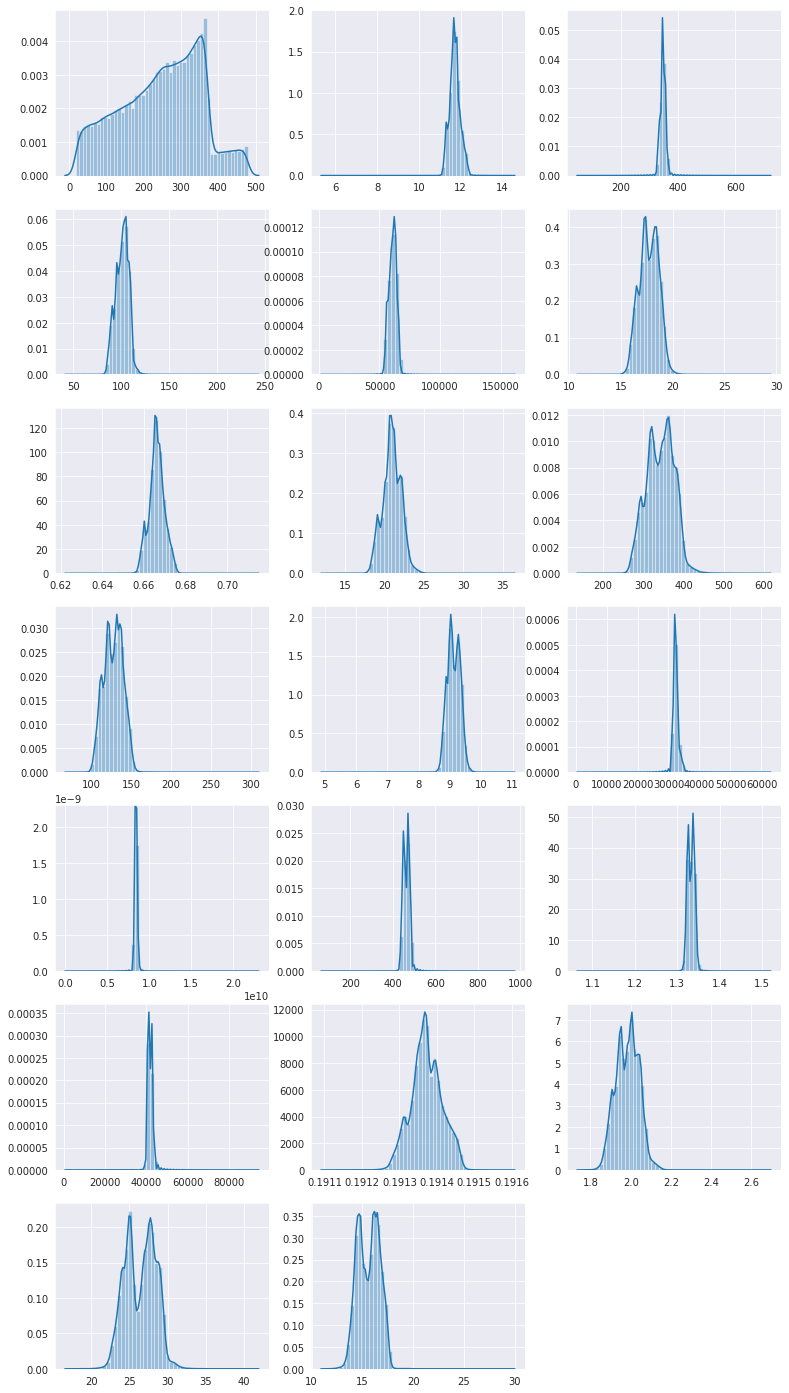

In [35]:

sns.set_style("darkgrid")
plt.figure(figsize=(13,25))
lambda_list = []
train_box = pd.DataFrame()
for i,col in enumerate(sc_col):
  ax1 = plt.subplot(7,3,i+1)
  #x, y = sp.stats.boxcox_normplot(train_x1.iloc[:,i], -2, 2)
  #plt.plot(x, y);
  y2, l = sp.stats.boxcox(set_data.iloc[:,i])
  train_box[col] = y2
  sns.distplot(y2, ax=ax1)
  #plt.axvline(x=l, color='r', ls="--");
  print(col ," optimal lambda:", l)
  lambda_list.append(l)

In [0]:
test_box = set_data.iloc[199837:,:]
train_box = set_data.iloc[:199837,:]

In [0]:
train_x_sc = scaler.fit_transform(train_box)
test_x_sc = scaler.transform(test_box)

train_x_sc = pd.DataFrame(train_x_sc,columns = train_box.columns,index = train_box.index)
test_x_sc = pd.DataFrame(test_x_sc,columns = test_box.columns,index=test_box.index)
# train_x_sc['fiberID'] =  train_x['fiberID']
# test_x_sc['fiberID'] =  test_x['fiberID']
# train_x_sc = train_x_sc.merge(train2_g,on = 'fiberID',how='left')
# test_x_sc = test_x_sc.merge(train2_g,on = 'fiberID',how='left')

In [0]:
# from sklearn.preprocessing import RobustScaler
# scaler =  RobustScaler()
# train_x_sc = scaler.fit_transform(train_x)
# test_x_sc = scaler.transform(test_x)

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.2, random_state=42)

for train_index, test_index in split.split(train_x_sc, train_y):
    x_train, y_train = train_x_sc[train_index], train_y[train_index]
    x_val, y_val = train_x_sc[test_index] , train_y[test_index]

,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
0,601,1.062425,0.836161,1.177710,1.402961,1.512051,0.718872,0.847015,1.257115,1.406226,1.627081,0.703217,0.695100,1.243423,1.319365,0.957945,0.929798,0.989206,1.297020,1.383621,1.530758,0.138953,0.153728,0.0,0.078125,0.225795,0.222338,0.136755,0.236407,0.072505,0.0,0.174609,0.336289,0.0,0.168303,0.245776,0.218744,0.519931,0.0,0.211485
1,788,0.222026,0.454453,0.812912,1.117739,1.104824,0.360529,0.516608,0.858823,1.134948,1.329019,0.258678,0.448775,0.950438,1.059836,1.062570,0.359165,0.633064,0.975334,1.205413,1.197521,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.128897,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,427,-1.513875,-1.675124,-1.530159,-1.335289,-1.175436,-1.534999,-1.676198,-1.477933,-1.227518,-1.046326,-1.113558,-1.085462,-1.173072,-0.972824,-0.744569,-1.348533,-1.458798,-1.240052,-1.036032,-0.850609,0.138953,0.169101,0.2,0.078125,0.157373,0.192693,0.158207,0.128949,0.068477,0.0,0.247363,0.076429,0.0,0.154278,0.092166,0.177729,0.000000,0.0,0.147120
3,864,-0.085715,0.100834,0.378557,0.597265,0.511319,-0.059584,0.131324,0.423939,0.610959,0.580965,-0.103259,0.151857,0.498226,0.601205,0.505249,0.028127,0.249239,0.516777,0.693087,0.690352,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.140981,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,612,2.584278,1.687920,1.267704,0.391258,-0.125805,2.262229,1.901846,1.306078,0.481656,-0.004213,1.994322,1.069930,1.340364,0.528227,-0.002224,1.881650,1.827508,1.355423,0.543932,0.061927,0.277906,0.169101,0.0,0.039062,0.218953,0.155636,0.171614,0.236407,0.128897,0.0,0.130957,0.305717,0.0,0.294530,0.215054,0.239251,0.346620,0.0,0.188497


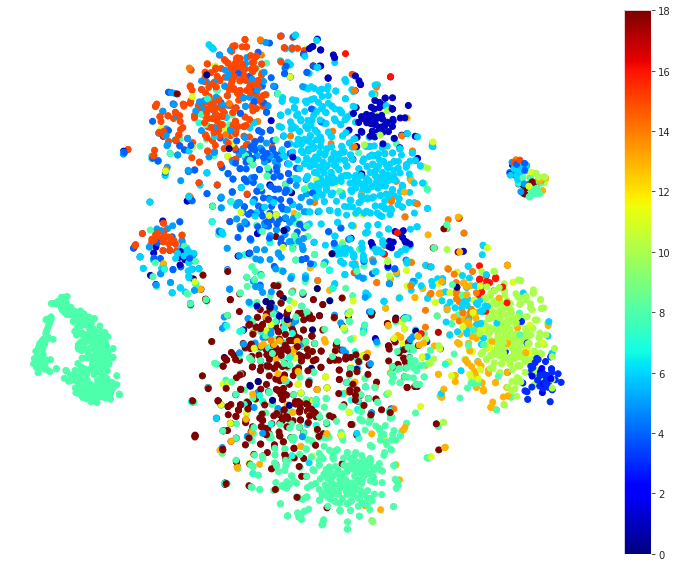

In [162]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pca = PCA()
X = pca.fit_transform(train_x_sc.iloc[:4000,:])
y = train_y[:4000]
tsne = TSNE(learning_rate=300, n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()

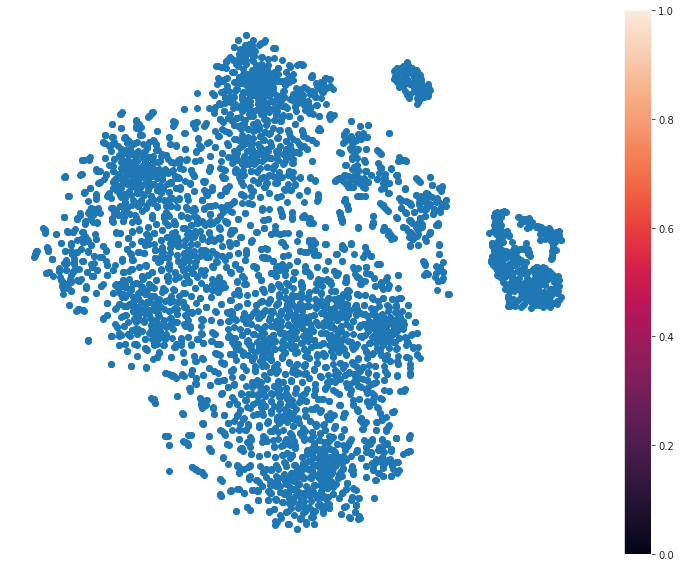

In [164]:
X = pca.transform(test_x_sc.iloc[:5000,:])
y = train_y[:4000]
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], cmap="jet")
plt.axis('off')
plt.colorbar()

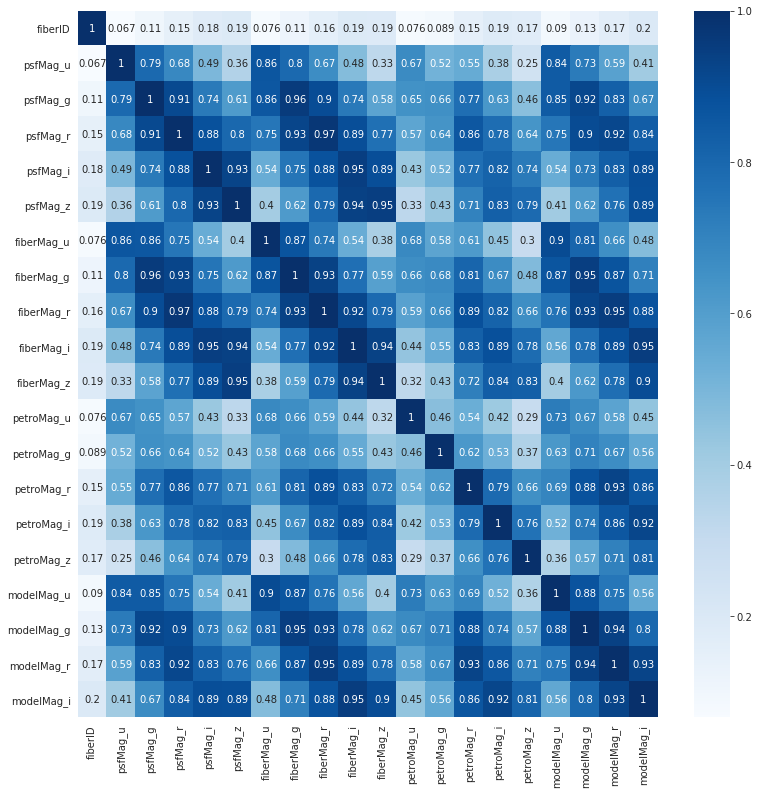

In [114]:
corrmat = train_x[sc_col].corr()
plt.figure(figsize=(13,13))
g = sns.heatmap(corrmat,annot=True,cmap="Blues")

In [115]:
y_train.value_counts()

8     39730
6     29843
18    17402
15    11703
4     11692
10    10998
5     10794
13     5705
11     5243
1      5204
7      3722
14     2605
3      2048
0      1728
16      923
2       400
9       102
17       49
12       11
Name: type_num, dtype: int64

In [0]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
X_samp, y_samp = SMOTETomek(random_state=123, smote=SMOTE(sampling_strategy='auto', ratio={7:4500,2:450,17:100,12:80}), 
                            tomek=TomekLinks(sampling_strategy='auto', ratio = {8:36800,6:27800,18:15800,7:3500})).fit_sample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [0]:
import lightgbm as lgb
def build_model(sub_sample_for_bin1, num_leaves1, max_depth1,min_child_weight1, min_data_in_leaf1, min_split_gain1, min_child_samples1):
  model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=num_leaves1,  min_split_gain=  min_split_gain1,
                               min_data_in_leaf = min_data_in_leaf1,
                               max_depth= max_depth1, learning_rate=0.01, n_estimators=3000, 
                               subsample_for_bin=sub_sample_for_bin1, objective='multiclass', 
                               min_child_weight=min_child_weight1, min_child_samples=min_child_samples1
                               ,n_jobs=-1, random_state=42)
  return model
def learning_rate_001_decay_power_099(current_iter):
    base_learning_rate = 0.01
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3
def fit_with(num_leaves1, max_depth1,min_child_weight1, min_data_in_leaf1, min_split_gain1,min_child_samples1):
    model = build_model(2500000, int(num_leaves1), int(max_depth1),min_child_weight1, int(min_data_in_leaf1), min_split_gain1,int(min_child_samples1))
    fit_model = model.fit(x_train,y_train,eval_set = [(x_val,y_val)], verbose= 500,
                          early_stopping_rounds=100)
    y_pred = model.predict_proba(x_val)
    
    return -log_loss(y_en.toarray(),y_pred)

# lgb_clf1 = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=60, max_depth=-1, learning_rate=0.003, 
#                              n_estimators=3000, subsample_for_bin=400000, objective='multiclass', min_split_gain=0.15, reg_alpha = 0.1, 
#                              min_child_weight=5e-3, min_child_samples=10,n_jobs=-1, random_state=42,)
# lgb_model1 = lgb_clf1.fit(x_train, y_train, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

In [0]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
encoder1 = OneHotEncoder()
y_en = encoder1.fit_transform(np.array(y_val).reshape(-1,1))

In [0]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {
    'num_leaves1':  (35, 70),
    'max_depth1': (15, 50),
    'min_child_weight1': (0.001, 1),                                              
    'min_child_samples1' : (5, 25),
    'min_data_in_leaf1' : (1,10),
    'min_split_gain1' : (0.05,0.5),
}

bayes_optimizer = BayesianOptimization(
    f=fit_with,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    # random_state=1
)

bayes_optimizer.maximize(init_points=15, n_iter=15)
for i, res in enumerate(bayes_optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   | max_de... | min_ch... | min_ch... | min_da... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's multi_logloss: 0.413833
[1000]	valid_0's multi_logloss: 0.380715
[1500]	valid_0's multi_logloss: 0.376597
[2000]	valid_0's multi_logloss: 0.37521
Early stopping, best iteration is:
[2187]	valid_0's multi_logloss: 0.374946
|  1        | -0.3749   |  38.38    |  7.03     |  0.1149   |  7.228    |  0.2764   |  49.64    |
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's multi_logloss: 0.422624
[1000]	valid_0's multi_logloss: 0.38607


KeyboardInterrupt: ignored

In [55]:
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=200, max_depth=-1, learning_rate=0.005, min_data_in_leaf = 4,
                             n_estimators=10000, subsample_for_bin=300000, objective='multiclass', min_split_gain=0.2, reg_alpha = 0.01, reg_lambda = 0.01,
                             min_child_weight=0.001, min_child_samples=17,n_jobs=-1, random_state=123,)
lgb_model = lgb_clf.fit(x_train, y_train, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

Training until validation scores don't improve for 50 rounds.
[200]	valid_0's multi_logloss: 0.921216
[400]	valid_0's multi_logloss: 0.599003


KeyboardInterrupt: ignored

In [73]:
lgb_clf1 = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=200, max_depth=-1, learning_rate=0.005, min_data_in_leaf = 5,
                             n_estimators=10000, subsample_for_bin=250000, objective='multiclass', min_split_gain=0.33, reg_alpha = 0.01, reg_lambda = 0.01,
                             min_child_weight=0.005, min_child_samples=17,n_jobs=-1, random_state=123,)
lgb_clf1.fit(X_samp, y_samp, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

NameError: ignored

In [0]:
y_test = lgb_model.predict_proba(test_x_sc)
submission = pd.DataFrame(data=y_test, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('/gdrive/My Drive/Data/submission1.csv', index=True)

In [0]:
from sklearn.metrics import confusion_matrix
y_pred = lgb_model.predict(x_train)
plt.figure(figsize=(13,13))
ax = sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt="d" 
                  ,yticklabels=sample_submission.columns, xticklabels=sample_submission.columns
                )

In [0]:
from sklearn.metrics import classification_report
classification_report(y_train,y_pred)

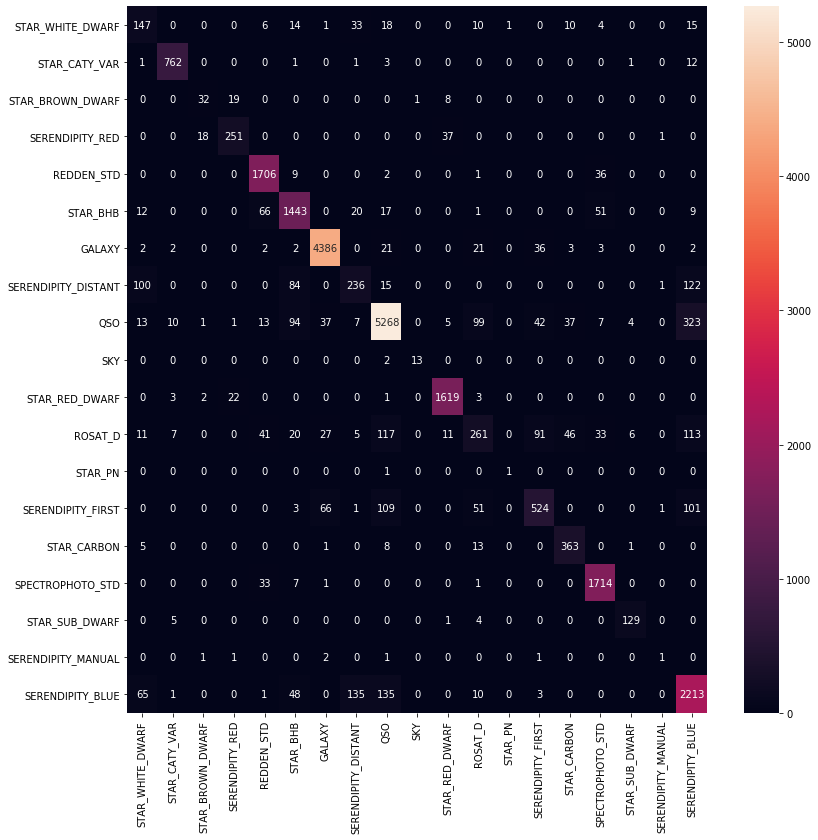

In [0]:
from sklearn.metrics import confusion_matrix
y_pred = lgb_model.predict(x_val)
plt.figure(figsize=(13,13))
ax = sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d" 
                  ,yticklabels=sample_submission.columns, xticklabels=sample_submission.columns
                )

In [0]:
pd.Series(y_samp).value_counts()

8     41293
6     32098
18    17315
4     12716
15    12377
10    11788
5     11740
13     7500
11     7000
7      6000
1      5660
0      3000
14     2834
3      2228
2      1800
17     1250
16     1004
12     1000
9       110
dtype: int64

In [0]:
from sklearn.svm import LinearSVC

In [0]:
svm_clf = LinearSVC(C=3,max_iter=3000,verbose=200,random_state=42)

In [0]:
svm_model = svm_clf.fit(X_samp,y_samp)

[LibLinear]

KeyboardInterrupt: ignored